# Lab 2: Network Intrusion Detection
 * Classification models for the "UNSW_NB15" network traffic data set.

In [1]:
# Imports
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt
from sklearn.svm import SVC

from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np


%matplotlib inline

E:\anaconda\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\anaconda\envs\py27\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
E:\anaconda\envs\py27\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning

In [2]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')

# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"      

df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] 

df_five.info()
df_five.describe()

duplicate record deleted successfully: 82328 observations remaining
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 6 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
label               82328 non-null int64
dtypes: int64(6)
memory usage: 4.4 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,1.000000


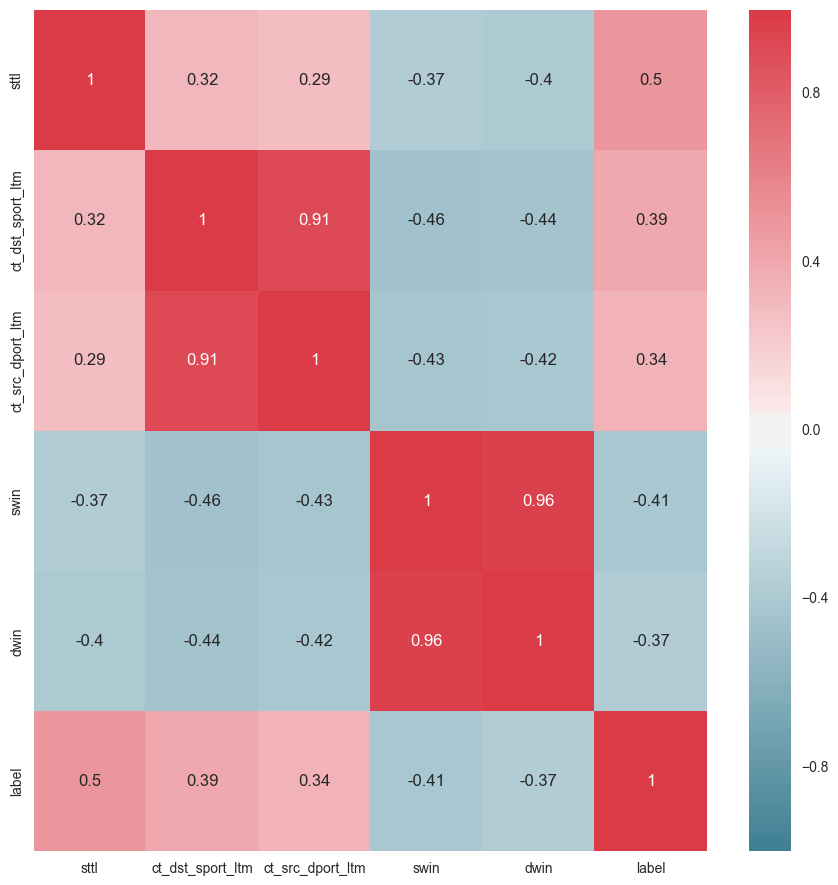

In [3]:
# plot the correlation matrix using seaborn
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_five.corr(), cmap=cmap, annot=True)

f.tight_layout()

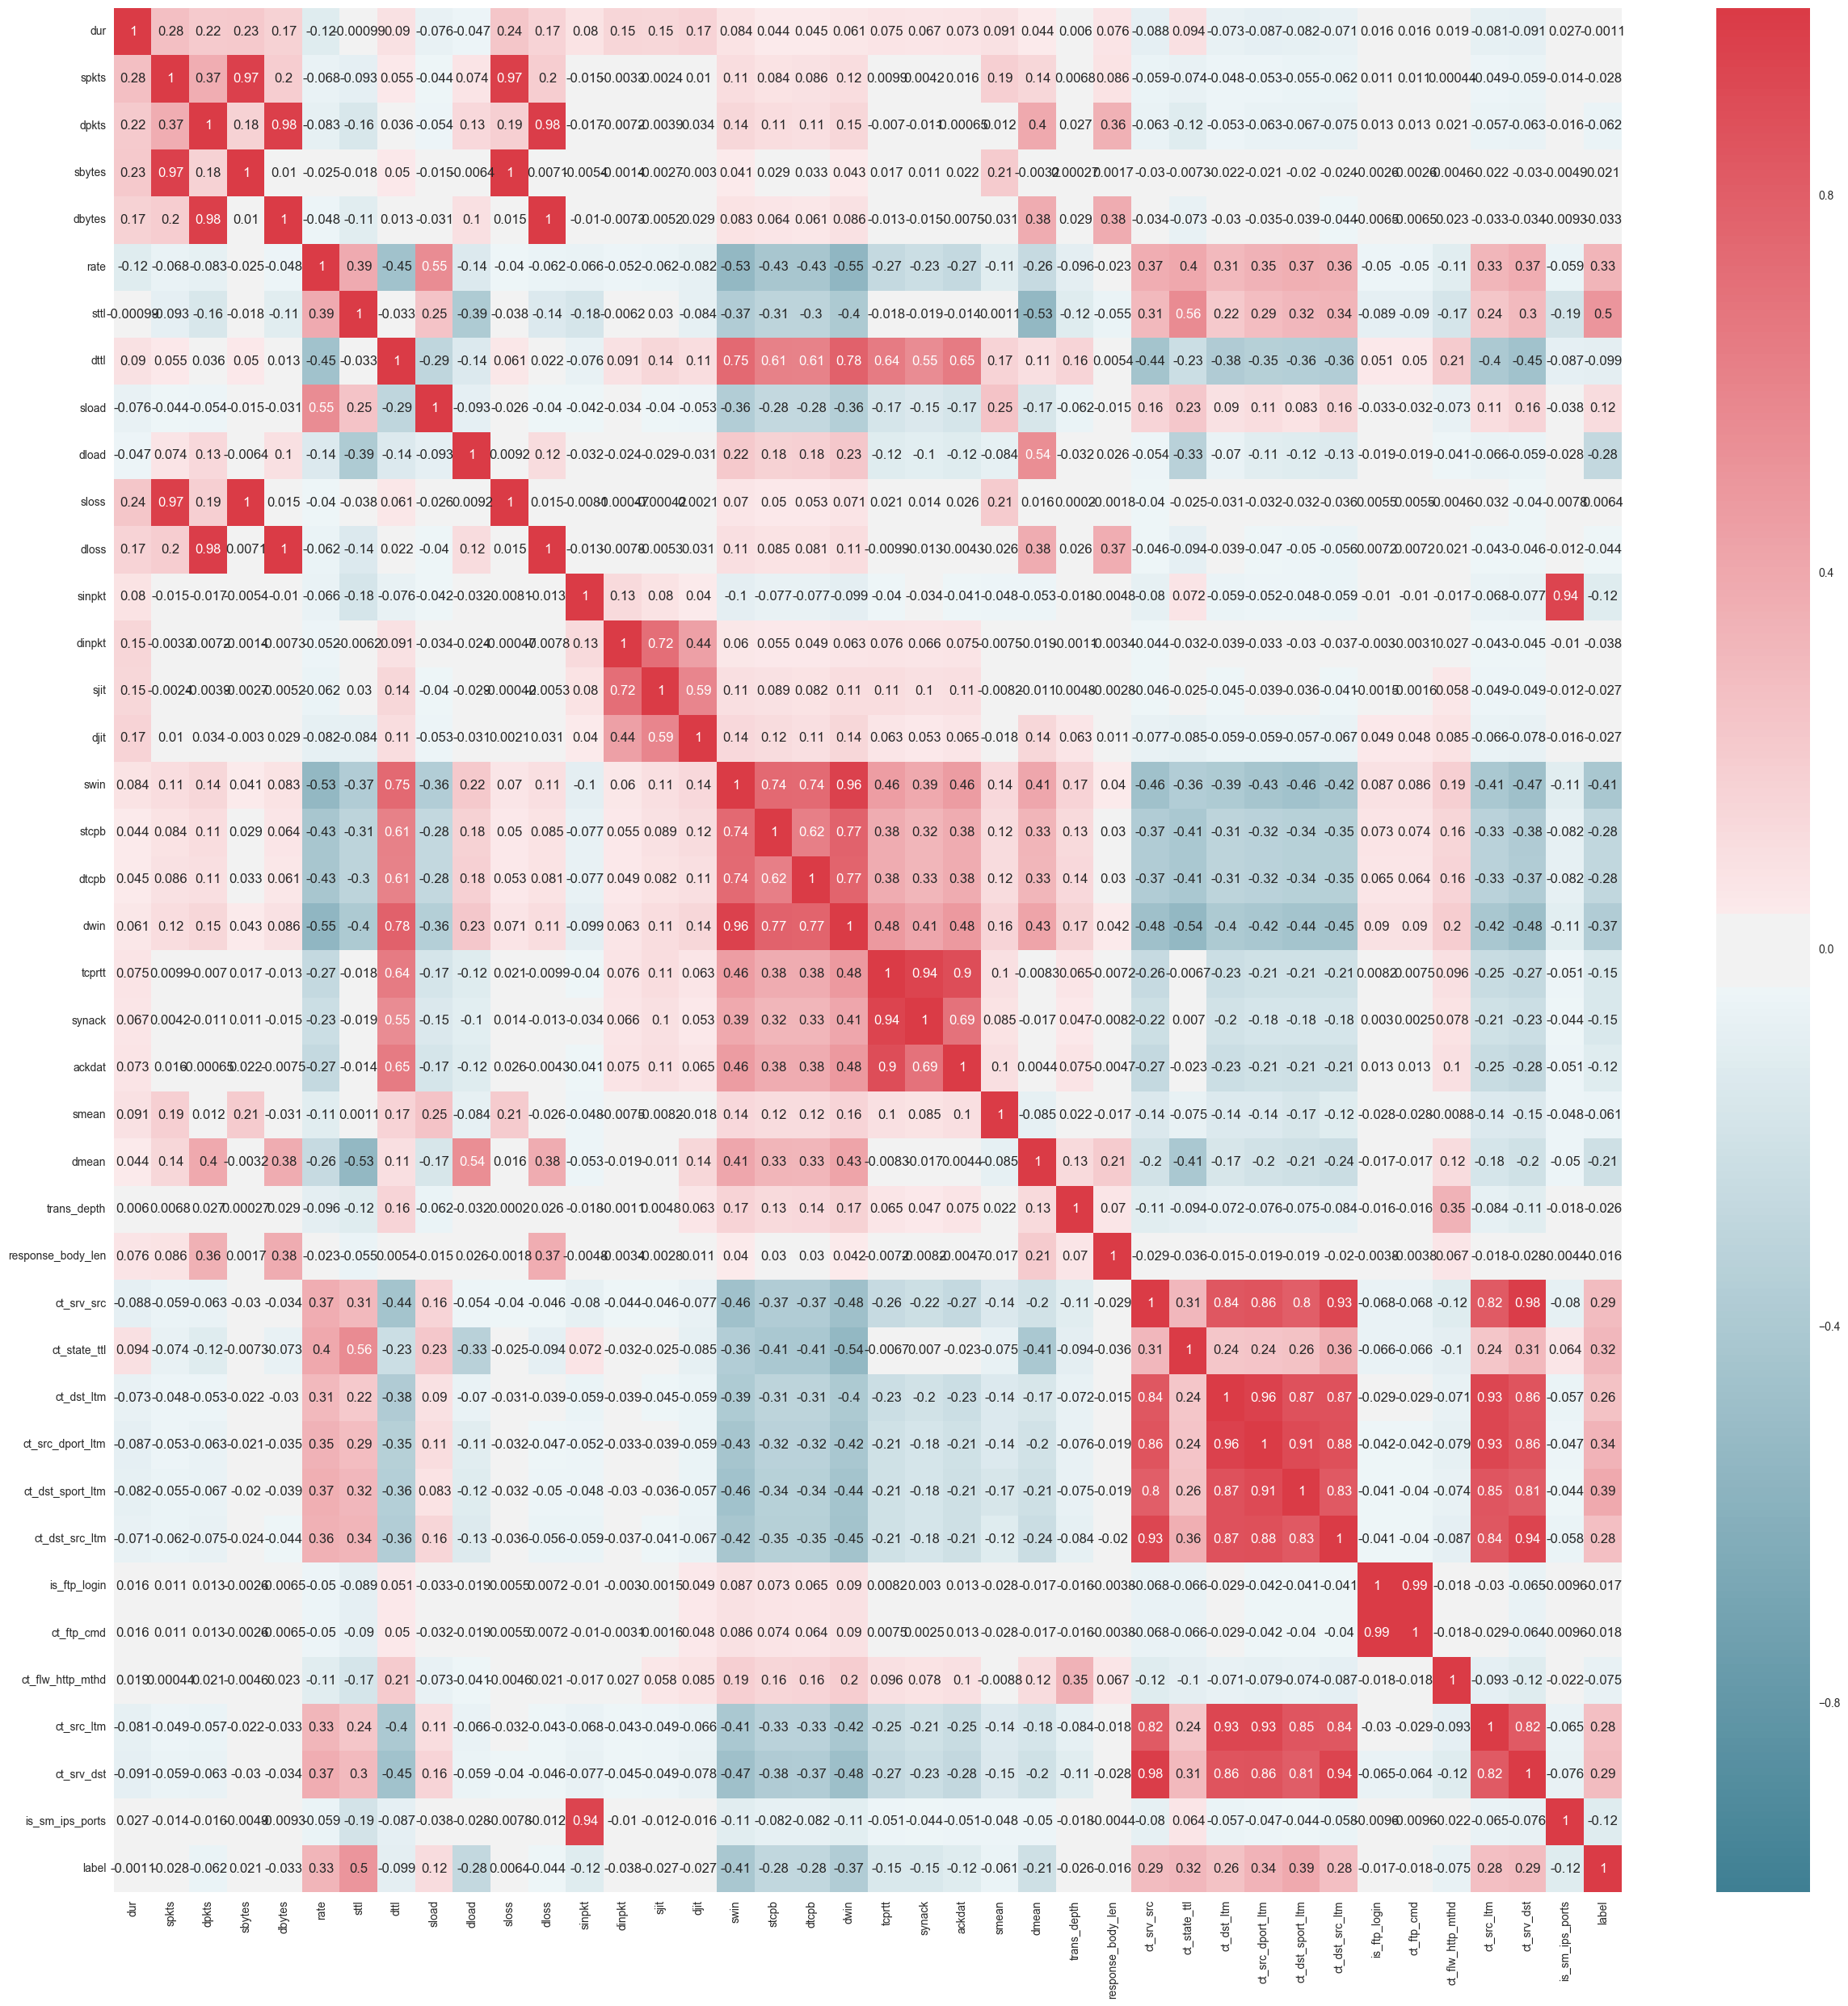

In [4]:
f, ax = plt.subplots(figsize=(25, 25))

sns.heatmap(df.corr(), cmap=cmap, annot=True)

f.tight_layout()

### df_five: Why is it significant?
* We chose df_five as our base model because those are the five features that are the most correlated to our response variable (label). 
    * As shown in the heatmaps above, we can see that these five features have the most apparent influence over *label*
        * In the heatmaps, we are focusing our attention on the bottom row (label) as it correlates to the rest of the features. 
        * We see that the five most correlated features are:
            * 'sttl',
            * 'ct_dst_sport_ltm', 
            * 'ct_src_dport_ltm', 
            * 'swin', 
            * 'dwin'

In [19]:
# based on feedback from mini lab, we want to check if accuracy increases from the selected 5 features to include the following
# two additional features: 'dttl', 'ct_dst_src_ltm',
df_seven = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'dttl', 'ct_dst_src_ltm', 'label' ]] # 
df_seven.info()
df_seven.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 8 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
dttl                82328 non-null int64
ct_dst_src_ltm      82328 non-null int64
label               82328 non-null int64
dtypes: int64(8)
memory usage: 5.7 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,dttl,ct_dst_src_ltm,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.00000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,95.70541,7.456528,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,116.66547,11.415443,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,29.00000,3.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,252.00000,6.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,253.00000,63.000000,1.000000


## Data Preparation:

* Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [3]:
# One-hot encode our object features:

# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)  # Note

Based on this one-hot encoding, the above categorical variables cause the features to increase based on sum of unique values. so $$43 + 131 + 13 + 7 - 3 = 191$$
Must subtract $3$ for the 3 original columns that exist

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(11), int64(29), uint8(151)
memory usage: 37.6 MB


We first want to answer the questions from our mini-lab assignment before we decide upon our initial dataset. df_five is the proposed dataset based on the results of the correlation map. df_seven incorporates two of the features that we found to have high weights in our mini lab. The question is, would adding a couple of the highest weighted features to the features we selected from the correlation matrix increase the accuracy? To test this we created both df_five and df_seven to test the hypothesis that df_seven affords no added bonus over df_five. We chose to do a quick test using logistic regression from the mini lab on both datasets. 

df_five and df_seven do not require one-hot encoding and are ready for modeling. First lets redo accuracy results for logistic regression on original 5 features selected based on correlation matrix from from lab 1 for accuracy comparision with additional 2 features suggested by grader using logistic regression model with 80/20 shuffle split cross validation to determine if we should proceed with original 5 or add additional two features for

In [45]:
# we want to predict the X and y data as follows for 5 feature iteration: 
if 'label' in df_five:
    y = df_five['label'].values # get the labels we want
    del df_five['label'] # get rid of the class label
    X = df_five.values # use everything else to predict!
    X_df_5 = X.copy() # used later for the Confidence Intervals
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print cv_object

ShuffleSplit(82328, n_iter=3, test_size=0.2, random_state=None)


In [17]:
# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
for train_indices, test_indices in cv_object:
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)

accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)
print "Average Accuracy (5 feature set) across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(np.average(accuracies))

[ 0.76442366  0.76952508  0.7652739 ]
Average Accuracy (5 feature set) across 3 shuffle split cross validation iterations = 0.766407546864


In [20]:
# we want to predict the X and y data as follows for 7 feature iteration: 
if 'label' in df_seven:
    y = df_seven['label'].values # get the labels we want
    del df_seven['label'] # get rid of the class label
    X = df_seven.values # use everything else to predict!

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

In [21]:
# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
for train_indices, test_indices in cv_object:
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)

accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)
print "Average Accuracy (7 feature set) across " + str(num_cv_iterations) + " shuffle split cross validation iterations = " + str(np.average(accuracies))

[ 0.77705575  0.77250091  0.77037532]
Average Accuracy (7 feature set) across 3 shuffle split cross validation iterations = 0.773310660351


Based on the results there was negligible increase in accuracy with respect to including the additional 2 features
requested by the grader in terms of explaining the data.  Hence we we stick with the original 5 based on correlation results
from mini lab.

* Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [10]:
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to predict!
dfcopy.info() # should have 190 entries
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

# determine if we have roughly the same percentage of  normal vs abnormal observations
# ref: http://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
# ref: http://www.gossamer-threads.com/lists/python/python/809232 (print percentage)
unique, counts = np.unique(y, return_counts=True)
uniqueClassCounts = dict(zip(unique, counts))    
totalObservations = len(y)
print uniqueClassCounts
print "Percent normal(0) is {0:.0%}".format(float(uniqueClassCounts[0])/totalObservations)
print "Percent attack(1) is {0:.0%}".format(float(uniqueClassCounts[1])/totalObservations)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 43 columns):
dur                  82328 non-null float64
proto                82328 non-null object
service              82328 non-null object
state                82328 non-null object
spkts                82328 non-null int64
dpkts                82328 non-null int64
sbytes               82328 non-null int64
dbytes               82328 non-null int64
rate                 82328 non-null float64
sttl                 82328 non-null int64
dttl                 82328 non-null int64
sload                82328 non-null float64
dload                82328 non-null float64
sloss                82328 non-null int64
dloss                82328 non-null int64
sinpkt               82328 non-null float64
dinpkt               82328 non-null float64
sjit                 82328 non-null float64
djit                 82328 non-null float64
swin                 82328 non-null int64
stcpb                82328 non-n

## Modeling and Evaluation:
### Metrics to analyze the models
* Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.


http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

Once you have a model that you believe can make robust predictions you need to decide whether it is a good enough model to solve your problem. Classification accuracy alone is typically not enough information to make this decision.

Classification accuracy is our starting point. It is the number of correct predictions made divided by the total number of predictions made, multiplied by 100 to turn it into a percentage.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).

P = T_p / (T_p+F_p)

Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).

R = (T_p) / (T_p + F_n)

These quantities are also related to the (F_1) score, which is defined as the harmonic mean of precision and recall.

F1 = 2 ( (P*R) / (P+R) )


http://hackercollider.com/articles/2016/06/03/recall-vs-precision/



With our particular dataset there are a couple of different view points on which performance metrics a model should be tuned for for this particular dataset:
1) False negatives are probably worse than false positives. If a malicious packet gets through undetected, it could potentially do bad things without being noticed, whereas a false positive could be rescreened or reviewed to clear the packet. Note: however, if the system has protection in depth, perhaps down stream systems may catch the packet or some effect of the malicous abnormal packet (e.g. host based intrusion detection system, so it may not be that bad).
Recall may be a good metric to gauge model performance based on highlighting false negatives. Recall is defined as the number of True Postivies divided by the number of True Positives and the number of False Negatives, also known as Sensitivity or the True Postive Rate. 

2) However, if there are too may false positives, where the system over classifies packets as malcious when they really aren't then it could be interfering with normal operations and impact business operations. On the assumption that it takes some signficant amount of time to clear a tagged (false) positive packet. If a tool identifies too many false positives, people would lose trust with the system. Based on this view, precision which is defined as the number of True Positives divided by the number of True Positives and False positives would be a good metric to use to gauge performance of models used for predicting abnormal packets.

3) Based on these view points, a metric which combines both would be the F1 Score which is 2*((precision*recall)/(precision+recall)) also know as the F Score or F Measure which tries to convey the balance between precision and recall. 

### Method to divide the data
*  Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

ref:
(a) http://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation
(b) http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
(c) http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/


Per ref (a) startification in general seeks to ensure each fold is representative of all strata in the data. The label feature has two classes (categories) as seen above normal(0) and attack(1) with percentages of 45% and 55%, respectively based on distribution of the classes with respect to the complete dataset. If it was 50%/50% one could argue a random sampling should create evenly distributed folds and with large enough sample size, should be sufficient. The main argument for stratification is to address the biasing effects of classification algorithms based on over/under representation of classes in any one particular sample or folds for classification algorithms that do not inherently have inherent balancing techniques either by selection or weighting.  According to ref (a), however, it does lead to a loss of diversity (unwanted loss of variance). Basically, the more unbalanced then the classes are, the more biased a classification algorithm in general would be to the observations tending to the more popular class. Stratification seeks to correct for that artificially to address algorithms that cleverly try and predict the class witht the highest weighting based on class distribution.

Since the values in the labels are not exactly equal, a stratified Kfold validation is recommended so that each set or fold contains approximately the same percentage of samples of each target class as the complete set.
Note: Will do both for comparision sake to see if there is any difference
in results and to get a feel for the methodology.

Note: per ref (a) To combat imbalanced training data, one technique woudl be to try and colect more data with a larger dataset.  However. since we did not generate this data ourselves, this would not be an option.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
#ref : http://stackoverflow.com/questions/2866380/how-can-i-time-a-code-segment-for-testing-performance-with-pythons-timeit
import time
#ref: http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html
numObservations = len(dfcopy)
print numObservations
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

num_folds = 10
kf = KFold(numObservations, n_folds=num_folds)
skf = StratifiedKFold(y, num_folds)

# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
print(kf)
t0 = time.clock()

for train_index, test_index in kf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0

accuracies = cross_val_score(lr_clf, X, y=y, cv=kf) # this also can help with parallelism
#print(accuracies)
print "Average Accuracy across " + str(num_folds) + " fold cross validation iterations = " + str(np.average(accuracies)) + " training time = " + str(total)    

t0 = time.clock()
for train_index, test_index in skf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
# http://scikit-learn.org/stable/modules/model_evaluation.html


accuracies = cross_val_score(lr_clf, X, y=y, cv=skf) # this also can help with parallelism
precision = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='precision')
recall = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='recall')
accuracy = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='accuracy')
f1 = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='f1')# just testing to see if it is same as default


#print(accuracies)
#print "Percent normal(0) is {0:.0%}".format(float(classCounts[0])/totalObservations)
print "Average Accuracies across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%} ".format(np.average(accuracies)) + " training time = " + str(total)    
print "Average Precision across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(precision)) + " training time = " + str(total)    
print "Average Recall(Sensitivity) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(recall)) + " training time = " + str(total)    
print "Average Accuracy across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(accuracy)) + " training time = " + str(total)    
print "Average F measure(F1) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(f1)) + " training time = " + str(total)    

# http://stackoverflow.com/questions/23339523/sklearn-cross-validation-with-multiple-scores
from sklearn import metrics
def mean_scores(X, y, clf, skf):

    cm = np.zeros(len(np.unique(y)) ** 2)
    for i, (train, test) in enumerate(skf):
        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        cm += metrics.confusion_matrix(y[test], y_pred).flatten()

    return compute_measures(*cm / skf.n_folds)

def compute_measures(tp, fp, fn, tn):
     """Computes effectiveness measures given a confusion matrix."""
     specificity = tn / (tn + fp)
     sensitivity = tp / (tp + fn)
     fmeasure = 2 * (specificity * sensitivity) / (specificity + sensitivity)
     return sensitivity, specificity, fmeasure
    
print mean_scores(X, y, lr_clf, skf)

82328
sklearn.cross_validation.KFold(n=82328, n_folds=10, shuffle=False, random_state=None)
Average Accuracy across 10 fold cross validation iterations = 0.717766267375 training time = 8.64873982526
Average Accuracies across stratified 10 fold cross validation iterations = 76%  training time = 9.29193030423
Average Precision across stratified 10 fold cross validation iterations = 79% training time = 9.29193030423
Average Recall(Sensitivity) across stratified 10 fold cross validation iterations = 82% training time = 9.29193030423
Average Accuracy across stratified 10 fold cross validation iterations = 76% training time = 9.29193030423
Average F measure(F1) across stratified 10 fold cross validation iterations = 79% training time = 9.29193030423
(0.75621391674263139, 0.75488688332186649, 0.75554981733859294)


The stratified 10 fold cross validation appears to have a higher accuracy score of 76% vs 71%. Not much difference in computational expense between the two cross validation methods.
    # https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/
   
   Sensitivy/recall measures how good the model is at detecting the positives, which somewhat important.

## Create the models
*  Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! 

#### Task One

For our **first task** we decided to run Logistic Regression, K-Nearest Neighbors, and Random Forest classifiers on our **`df_five`** data set. The objective of the models is to determine whether an instance of the network traffic is an attack on the system [1] or not [0]. 

In [26]:
# we want to predict the X and y data as follows for 5 feature iteration: 
if 'label' in df_five:
    y = df_five['label'].values # get the labels we want
    del df_five['label'] # get rid of the class label
    X = df_five.values # use everything else to predict!

In [46]:
cv_object = StratifiedKFold(10)

In [13]:
# Model: Logistic Regression
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

pipe = Pipeline(steps=[('logistic', lr_clf)])

grid = dict(logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])

scores = ['precision', 'recall', 'f1', 'accuracy']


for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Wall time: 3min 35s
precision 0.791926796693
precision {'logistic__C': 10000.0, 'logistic__penalty': 'l2'}
Wall time: 3min 53s
recall 0.847092228311
recall {'logistic__C': 1.0, 'logistic__penalty': 'l1'}
Wall time: 3min 40s
f1 0.806651944408
f1 {'logistic__C': 10000.0, 'logistic__penalty': 'l2'}
Wall time: 3min 53s
accuracy 0.763081819065
accuracy {'logistic__C': 10000.0, 'logistic__penalty': 'l2'}


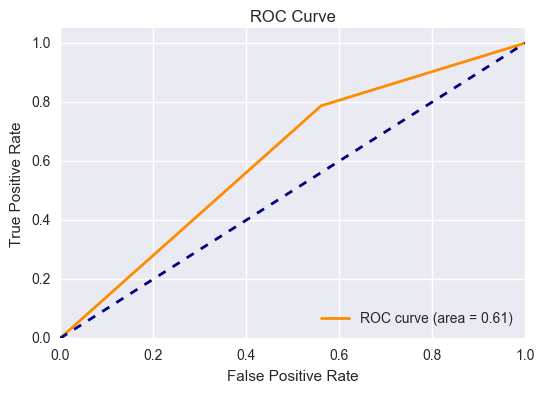

In [23]:
# Since we are using f1 and accuracy as our metrics for goodness, we'll run an ROC curve on 
# the best fitting parameters are a C of 10000 and a logistic penalty of l2
lr_clf = LogisticRegression(penalty="l2", C=10000)
for train_index, test_index in cv_object.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Model: Random Forest
num_trees = 100
max_features = 5
clf = RandomForestClassifier(n_jobs=-1)

pipe = Pipeline(steps=[('forest', clf)])

grid = dict(forest__n_estimators=[1, 10, 50, 100, 200],
            forest__max_features=[1, 2, 3, 4, 5])

for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Wall time: 4min 49s
precision 0.826528086423
precision {'forest__max_features': 1, 'forest__n_estimators': 10}
Wall time: 5min 25s
recall 0.879104366388
recall {'forest__max_features': 3, 'forest__n_estimators': 1}
Wall time: 5min 33s
f1 0.819553007007
f1 {'forest__max_features': 3, 'forest__n_estimators': 50}
Wall time: 5min 57s
accuracy 0.796484792537
accuracy {'forest__max_features': 4, 'forest__n_estimators': 1}


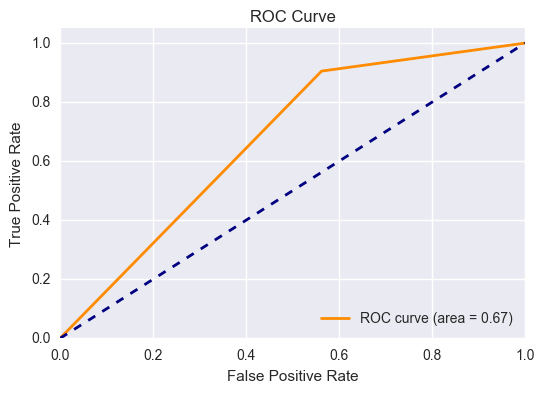

In [29]:
# Since we are using f1 and accuracy as our metrics for goodness, we'll run an ROC curve on 
# the best fitting parameters are a estimators of 50 and a max features of 3.
clf = RandomForestClassifier(n_estimators=50, max_features=3, n_jobs=-1)
for train_index, test_index in cv_object.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the classifier on the training data
    clf.fit(X_train, y_train)  # train object
    y_hat = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Model: K-Nearest Neighbors
clf = KNeighborsClassifier(n_jobs=-1)

pipe = Pipeline(steps=[('knn', clf)])

grid = dict(knn__n_neighbors=list(range(1,21)),
            knn__weights=['uniform', 'distance'])

for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Wall time: 35min 51s
precision 0.78846869838
precision {'knn__weights': 'distance', 'knn__n_neighbors': 2}
Wall time: 37min 52s
recall 0.94670054391
recall {'knn__weights': 'uniform', 'knn__n_neighbors': 5}
Wall time: 34min 12s
f1 0.836373403825
f1 {'knn__weights': 'uniform', 'knn__n_neighbors': 1}
Wall time: 32min 47s
accuracy 0.785759401419
accuracy {'knn__weights': 'uniform', 'knn__n_neighbors': 1}


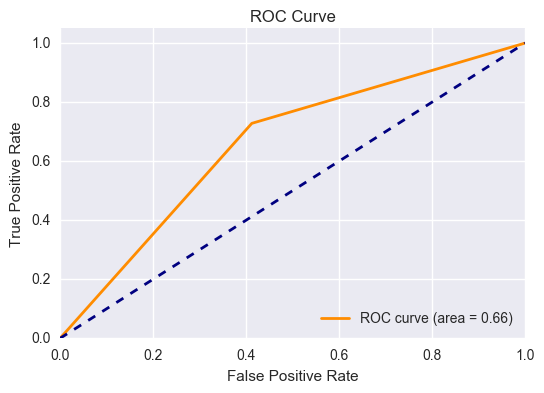

In [33]:
# Since we are using f1 and accuracy as our metrics for goodness, we'll run an ROC curve on 
# the best fitting parameters are:
clf = KNeighborsClassifier(weights="uniform", n_neighbors=1, n_jobs=-1)
for train_index, test_index in cv_object.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the classifier on the training data
    clf.fit(X_train, y_train)  # train object
    y_hat = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Task Two:

For our **second task** we decided to run Logistic Regression, K-Nearest Neighbors, and Random Forest classifiers on our **`pca`** data set. The objective of the models is to determine whether an instance of the network traffic is an attack on the system [1] or not [0].

In [4]:
# we want to predict the X and y data as follows for df: 
df_copy = df.copy()
if 'label' in df:
    y = df['label'].values # get the labels we want
    del df['label'] # get rid of the class label
    X = df.values # use everything else to predict!
    df = df_copy

In [53]:
pca = PCA(n_components=25)
x_pca = pca.fit(X)

# Percentage of variance explained for each components
print('explained variance ratio (first 20 components): %s' % (100 * pca.explained_variance_ratio_) )
print(sum(pca.explained_variance_ratio_))

explained variance ratio (first 20 components): [  8.06264871e+01   1.86189186e+01   7.54450766e-01   1.41709791e-04
   7.59141703e-07   5.89835762e-07   3.38115635e-07   8.21339103e-08
   3.15831460e-08   9.56764680e-10   2.18744337e-10   2.06229133e-11
   9.27743793e-13   7.64692887e-13   2.72244896e-13   1.59932547e-13
   5.94899743e-14   1.52615198e-14   1.16825353e-14   1.00265589e-14
   2.71310234e-15   8.21833271e-16   4.60945924e-16   4.09049271e-16
   2.05827180e-16]
1.0


In [37]:
pca = PCA(n_components=3)
x_pca = pca.fit(X)

# Percentage of variance explained for each components
print('explained variance ratio (first 3 components): %s' % (100 * pca.explained_variance_ratio_) )
print(sum(pca.explained_variance_ratio_))

explained variance ratio (first 3 components): [ 80.62648709  18.61891863   0.75445077]
0.999998564882


We can see that using 3 components in the PCA explains 99.999% of our variance

In [41]:
# Scale data to have zero mean and unit variance to ensure that
# down stream classification algorithms that are sensitive and unfairly 
# weight association due to large scaled features  are densensitized to that
# effect. Also when performing PCA for feature redution, since PA yields a feature
# subspace that maximizes variance along the axes, it makes sense to standardize
# the data, especially since the features appear to be on different scales.

scaler = preprocessing.StandardScaler().fit(X)
scaler.mean_
scaler.scale_
scaler.transform(X)

array([[-0.21372809, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21372873, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21372936, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       ..., 
       [-0.21373043, -0.13192245, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21373043, -0.13192245, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21372851, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521]])

[  3.12577565e+18   7.21829322e+17   2.92489964e+16   5.49388956e+12
   2.94308575e+10   2.28671040e+10   1.31082682e+10   3.18421633e+09
   1.22443421e+09   3.70924227e+07   8.48041068e+06   7.99521381e+05
   3.59673237e+04   2.96460691e+04   1.05545522e+04]


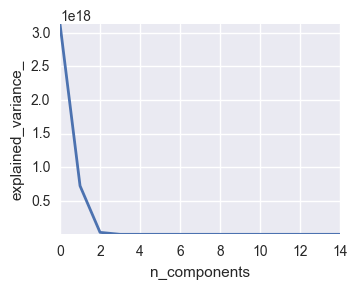

In [11]:
pca = PCA()
pca.fit(X)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_[:15], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
print pca.explained_variance_[:15]

[  8.06264871e-01   1.86189186e-01   7.54450766e-03   1.41709791e-06
   7.59141703e-09   5.89835762e-09   3.38115635e-09   8.21339103e-10
   3.15831460e-10   9.56764680e-12   2.18744337e-12   2.06229133e-13
   9.27743792e-15   7.64692886e-15   2.72244895e-15]


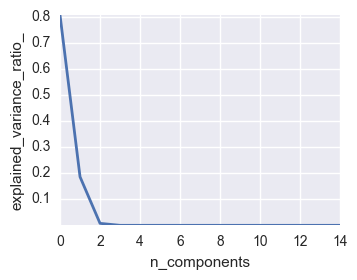

In [12]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_[:15], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
print pca.explained_variance_ratio_[:15]

Using these graphs of the explained variance and explained variance ratio, we see that the is a clear "elbow" at two components. Using the above data that three components accounts for 99.999% of the variance, we will start out our PCA components with the options of 2, 3, and 5. 

In [7]:
# Model: Logistic Regression
pca = PCA()
clf = LogisticRegression() # get object
pipe = Pipeline(steps=[("pca", pca),
                       ('logistic', clf)])

grid = dict(pca__n_components=[2, 3, 5],
            logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])
scores = ["f1"]
for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Wall time: 24min 58s
f1 0.747974399749
f1 {'logistic__C': 1.0, 'pca__n_components': 5, 'logistic__penalty': 'l1'}


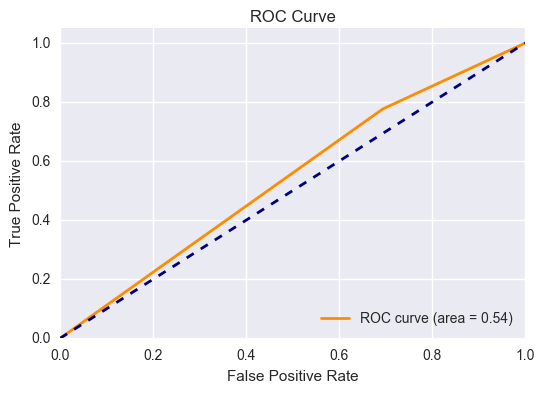

In [20]:
# http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# Since we are using f1 and accuracy as our metrics for goodness, we'll run an ROC curve on 
# the best fitting parameters are:

clf = LogisticRegression(penalty="l1", C=1.0)
for train_index, test_index in cv_object.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pca = PCA(n_components=5).fit(X_train)
    X_train_pca = pca.transform(X_train)    
    X_test_pca = pca.transform(X_test)
    
    # train the classifier on the training data
    clf.fit(X_train_pca, y_train)  # train object
    y_hat = clf.predict(X_test_pca)
    
    
    


fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

We see that the Logistic Regression PCA model decided upon using the 5 components, so for Random Forest, lets see if it will go up any higher on the number of components that it will use.

In [12]:
# Model: Random Forest
print "Model: Random Forest"
num_trees = 100
max_features = 5
clf = RandomForestClassifier(n_jobs=-1)

pca = PCA()
pipe = Pipeline(steps=[("pca", pca), 
                       ('forest', clf)])

grid = dict(pca__n_components=[3, 5, 10],
            forest__n_estimators=[1, 10, 50],
            forest__max_features=[1, 2, 3])

for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Model: Random Forest
Wall time: 4min
f1 0.849161421148
f1 {'forest__max_features': 3, 'pca__n_components': 10, 'forest__n_estimators': 50}


Again, the best F1 score was for more components than the three we thought we would see used. We are going to raise the component up to 20 and see how the score goes, if it selects 20 components, then we will raise it up to a limit of 30.

In [14]:
# Model: Random Forest
print "Model: Random Forest 2"
num_trees = 100
max_features = 5
clf = RandomForestClassifier(n_jobs=-1)

pca = PCA()
pipe = Pipeline(steps=[("pca", pca), 
                       ('forest', clf)])

grid = dict(pca__n_components=[3, 5, 20],
            forest__n_estimators=[1, 10, 50],
            forest__max_features=[1, 2, 3])

for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Model: Random Forest 2
Wall time: 3min 40s
f1 0.888648812365
f1 {'forest__max_features': 3, 'pca__n_components': 20, 'forest__n_estimators': 50}


In [16]:
# Model: Random Forest
print "Model: Random Forest 3"
num_trees = 100
max_features = 5
clf = RandomForestClassifier(n_jobs=-1)

pca = PCA()
pipe = Pipeline(steps=[("pca", pca), 
                       ('forest', clf)])

grid = dict(pca__n_components=[20, 25, 30],
            forest__n_estimators=[1, 10, 50],
            forest__max_features=[1, 2, 3])

for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Model: Random Forest 3
Wall time: 4min 32s
f1 0.896401759299
f1 {'forest__max_features': 3, 'pca__n_components': 25, 'forest__n_estimators': 50}


In [24]:
# Model: Random Forest
print "Model: Random Forest 3 measuring for accuracy"
num_trees = 100
max_features = 5
clf = RandomForestClassifier(n_jobs=-1)

pca = PCA()
pipe = Pipeline(steps=[("pca", pca), 
                       ('forest', clf)])

grid = dict(pca__n_components=[20, 25, 30],
            forest__n_estimators=[1, 10, 50],
            forest__max_features=[1, 2, 3])
scores = ["accuracy"]
for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Model: Random Forest 3 measuring for accuracy
Wall time: 18min 21s
accuracy 0.947186862307
accuracy {'forest__max_features': 3, 'pca__n_components': 25, 'forest__n_estimators': 50}


The Random Forest PCA model used 25 components as the best parameters for both the F1 score and accuracy. Using this information, we will run the ROC curve and see how well it explains the True Positives to False Positives.

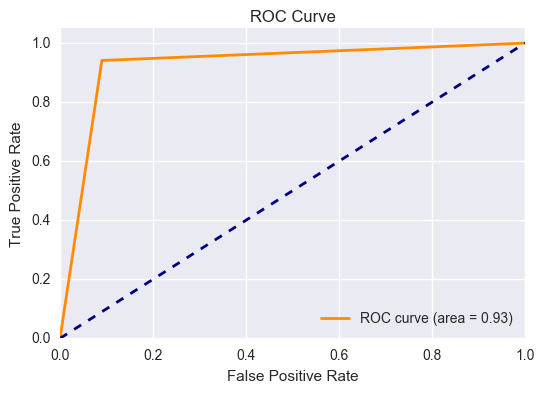

In [21]:
# Since we are using f1 and accuracy as our metrics for goodness, we'll run an ROC curve on 
# the best fitting parameters are a estimators of XX and a max features of XX.
clf = RandomForestClassifier(n_estimators=50, max_features=3, n_jobs=-1)
for train_index, test_index in cv_object.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pca = PCA(n_components=25).fit(X_train)
    X_train_pca = pca.transform(X_train)    
    X_test_pca = pca.transform(X_test)
    
    # train the classifier on the training data
    clf.fit(X_train_pca, y_train)  # train object
    y_hat = clf.predict(X_test_pca)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

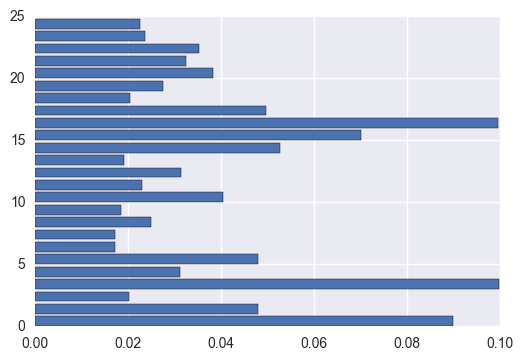

In [55]:
# Show the feature importance of the components. 
clf = RandomForestClassifier(n_estimators=50, max_features=3, n_jobs=-1)
for train_index, test_index in cv_object.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pca = PCA(n_components=25).fit(X_train)
    X_train_pca = pca.transform(X_train)    
    X_test_pca = pca.transform(X_test)
    
    # train the classifier on the training data
    clf.fit(X_train_pca, y_train)  # train object
    y_hat = clf.predict(X_test_pca)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

Because the ROC curve was very good, we decided to see which components are providing the most importance in the model. The bar chart above shows that 1, 4, 16, and 17 are all influential on the model. This must be why the model kept pushing for more and more components. We'll see next how many components the K-Nearest Neighbor does.

In [17]:
# Model: K-Nearest Neighbors
clf = KNeighborsClassifier(n_jobs=-1)

pipe = Pipeline(steps=[("pca", pca),
                       ('knn', clf)])

grid = dict(pca__n_components=[5, 15, 25],
            knn__n_neighbors=[1, 2, 5],
            knn__weights=['uniform', 'distance'])

for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Wall time: 7min 54s
f1 0.806385532178
f1 {'pca__n_components': 25, 'knn__weights': 'distance', 'knn__n_neighbors': 5}


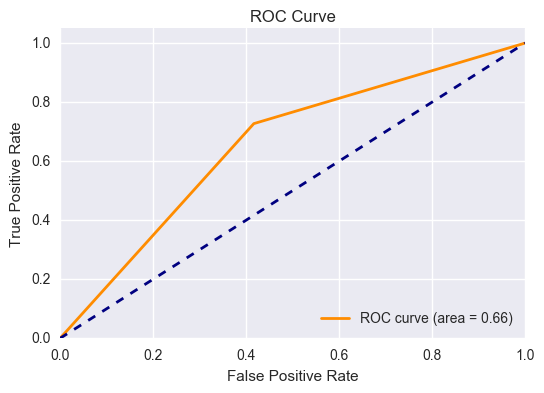

In [23]:
# Since we are using f1 and accuracy as our metrics for goodness, we'll run an ROC curve on 
# the best fitting parameters are a estimators of XX and a max features of XX.
clf = KNeighborsClassifier(weights="distance", n_neighbors=5, n_jobs=-1)
for train_index, test_index in cv_object.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pca = PCA(n_components=25).fit(X_train)
    X_train_pca = pca.transform(X_train)    
    X_test_pca = pca.transform(X_test)
    
    # train the classifier on the training data
    clf.fit(X_train_pca, y_train)  # train object
    y_hat = clf.predict(X_test_pca)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Analysis

*  Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

We can see from the above models, that the Random Forest classifier with the PCA dataset of 25 components meets our criteria the best. Looking at the F1 statistic, we see that it scored 0.896401759299 with an accuracy of 0.947186862307. This tells us that it does a good job of predicting True Positives and avoids False Positives. This is illustrated in our use of the ROC Curve. The ROC Curve has the percentage of True Positives on the y-axis and percentage of False Positives on the x-axis. The curve is the number of False Positives that are generated for a level of True Positives. Ideally, this curve will be heavy in the upper left corner (high True Positives and low False Positives) and will have an area under the curve close to one. Reviewing, we see that most of our models area under the curve is closer to 0.6, except for the Random Forest classifier that has a area under the curve of 0.93. This is important because prospective users of this model can have confidence that the traffic that is marked as an "attack" is actually an attack. 

* Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation. 

https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms

### Logistic Regression ###
Logistic Regression (LR) is a fairly well-behaved classification algorithm which can be trained on features that are generally linear and as a rule of thumb is recommended as a starting point for classification to set a baseline for other classification comparrsions.  Additional advantages and disadvantages are:

**Advantages**
* Robust to noise
* Avoid overfitting and even do feature selection by using l2 or l1 regularization.
* Used in Big Data scenarios since it is pretty efficient
* Distributed using, for example, ADMM (see logreg).
* Output can be interpreted as a probability which allows for ranking instead of classification.
* Low variance
* Provides probabilities for outcomes
* Works well with diagonal (feature) decision boundaries
* NOTE: logistic regression can also be used with kernel methods

**Disadvantages**
* High bias
* Cannot deal with missing values
* Requiring to impute the missing values (or substitute them with a mean or median).


https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=5&cad=rja&uact=8&ved=0ahUKEwiJi87y243QAhXmjFQKHbEbB-cQFggvMAQ&url=http%3A%2F%2Fhome.etf.rs%2F~vm%2Fos%2Fdmsw%2FRandom%2520Forest.pptx&usg=AFQjCNEVo5hQOuo-6p2g3Tsa_snZfjlNnA&sig2=x5GDssT9R0WG1GaFb0pXYw&bvm=bv.137901846,d.cGw

### Random Forest ###
Random Forest (RF) is a tree ensemble that has several advantages over LR.  One of the main advantages of RF is linearity of features is not expected.  Tree ensembles such as RF handle categorical features well as well as high dimensional spaces and large number of training examples. Additional advantages and disadvantages are:

**Advantages**
* One of the more accurate learning algorithms available.
* Produces a highly accurate classifier for most datasets.
* Efficient on large databases.
* Supports thousands of input variables without variable deletion.
* Estimates what variables are important in the classification.
* It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
* Supports methods for balancing error in class population unbalanced data sets. 

**Disadvantages**
* Can overfit some datasets with noisy classification/regression tasks.
* Biased towards categorical variables with attributes containing more levels.  This can cause the variable importance scrores not to be reliable.


https://en.wikibooks.org/wiki/Data_Mining_Algorithms_In_R/Classification/kNN

### KNN ###
K-Nearest Neighbors (KNN) is a simple algorithm that stores all available cases and classifies new cases based on distance functions.  KNN can be used for both classification and regression predictive problems.

**Advantages**
* Very simple implementation.
* Robust with regard to the search space; for instance, classes don't have to be linearly separable.
* Classifier can be updated online at very little cost as new instances with known classes are presented.
* Few parameters to tune: distance and k.
* Offers noise reduction techniques that can be effective in improving the accuracy of the classifier.

**Disadvantages**
* Large storage requirements
* Computationally intensive recall
* Can have poor run-time performance if the training set is large
* Highly susceptible to dimensionality
* Expensive testing of each instance due to computing distance to all known instances. 
* Sensitive to noisy or irrelevant attributes, which can result in less meaningful distance numbers. 
* Sensitive to very unbalanced datasets, where most entities belong to one or a few classes.


We did notice that Random Forest was the most computationally performant while logistic regression with the PCA was the slowest to run.

To measure the statistical significance of our best model, we decided to use Dr. Larson's code from the Classification notebook.
https://github.com/eclarson/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
We adjusted it to run in a loop and to use the F1 statistic instead of accuracy. The results and analysis are shown belown.

In [56]:
clf_lr = LogisticRegression(penalty="l2", C=10000)
clf_forest = RandomForestClassifier(n_estimators=50, max_features=3, n_jobs=-1)
clf_knn = KNeighborsClassifier(weights="uniform", n_neighbors=1, n_jobs=-1)
clf_lr_pca = LogisticRegression(penalty="l1", C=1.0)
clf_forest_pca = RandomForestClassifier(n_estimators=50, max_features=3, n_jobs=-1)
clf_knn_pca = KNeighborsClassifier(weights="distance", n_neighbors=5, n_jobs=-1)


f1_lr = cross_val_score(clf_lr, X_df_5, y=y, cv=cv_object, scoring="f1")
f1_forest = cross_val_score(clf_forest, X_df_5, y=y, cv=cv_object, scoring="f1")
f1_knn = cross_val_score(clf_knn, X_df_5, y=y, cv=cv_object, scoring="f1")
f1_lr_pca = cross_val_score(clf_lr_pca, X, y=y, cv=cv_object, scoring="f1")
f1_forest_pca = cross_val_score(clf_forest_pca, X, y=y, cv=cv_object, scoring="f1")
f1_knn_pca = cross_val_score(clf_knn_pca, X, y=y, cv=cv_object, scoring="f1")

In [57]:
model_f1 = [("logistic"    , f1_lr),
            ("forest"      , f1_forest),
            ("KNN"         , f1_knn),
            ("logistic_pca", f1_lr_pca),
            ("KNN_pca"     , f1_knn_pca)]

t = 2.26 / np.sqrt(10)
model_1, f1_1 = ("forest_pca", f1_forest_pca)
print "Confidence against model:", model_1
for model, f1_2 in model_f1:
    e = (1-f1_1)-(1-f1_2)
    stdtot = np.std(e)
    dbar = np.mean(e)
    print 'Range of: (', dbar-t*stdtot, ",", dbar+t*stdtot , ") against model", model

Confidence against model: forest_pca
Range of: ( -0.265355162702 , -0.161380598996 ) against model logistic
Range of: ( -0.136276502789 , -0.0821969889596 ) against model forest
Range of: ( -0.269990852043 , -0.157652693062 ) against model KNN
Range of: ( -0.0872142824459 , -0.0504533910992 ) against model logistic_pca
Range of: ( -0.148317276787 , -0.122733393112 ) against model KNN_pca


Here we are comparing our best model against the rest of the models we created for each task. We can see that the Random Forest PCA model is statistically different from all the other models that we tried. We know this because zero is not contained in any of the 95% confidence intervals.

* Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

As we can see in the horizontal barchart for the Random Forest model with PCA, the first, fourth, sixteenth, and seventeenth components are the most influential of the dataset. This explains why 99.999% of the variance is explained by the first three components, but 

## Deployment:
* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

In this phase, we understand that our evaluation model has met business objectives and is receiving reliable score data. Making the model exceptionally useful for businesses & organizations seeking to protect assets from potential cyberattacks. The model’s performance and desirability rests on some identified variables being, the overall performance of the model to protect from attacks, the costs associated with attacks landed/ missed, and also “how well does the model grow?” These factors could help a customer’s decision making process to employing an algorithmic method. Ultimately our job would be to efficiently and effectively scale the methodology appropriately for each customer. Interested customers would have a clear understanding of the nature of their business and the amount of protection needed for their size of an organization. To properly deploy a model to the customer, they would need to be aware of the overhead related in performing certain algorithms, mostly being time and money. The updating process of such a model could be continuous, either by streaming in live time by the seconds or delivered in blocks of time, such as hourly/daily/weekly.

The customer would also have to make a decision on whether they wanted real time cyber attack protection or log scans. Real time coverage has overhead to consider, such as latency that the algorithm will cause, especially in high throughput networks. Log anaysis is much easier to implement, and if ran regularly enough, it may give the customers the reassurance they need that they have not been breached.

## Exceptional Work:

You have free reign to provide additional analyses

• One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?

For our exceptional work, we want to take the best of both our task. We want to take the top 5 features and combine them with the best PCA components. To do this we decided that to use the SelectKBest class in the scikit-learn library. This scores all the features and selects the top ones, in our case we want the top 5 features. We use FeatureUnion to create our feature set. From there it is easy as putting the code into a pipeline and letting the do the work. 

The classifier we started with for this endeavor is the Random Forest classifier that gave us the best performance of our two task above. We are again focusing on the F1 statistic due to its usefullness with our dataset and business objectives. We also tried running it against the Logistic Regression and K Nearest Neighbors classifier

One issue we ran into was combining the PCA with another dataset was that we could not run the combined features on two different datasets or a subset of the dataset. So, we could not fit the combined_features on the X for the PCA and X_df_five. This led us to using the SelectKBest function. Although we wanted to use the five features of df_five, we were not able to programmatically find a way of doing that. But, we are hopeful that the SelectKBest can do a better job than we can at picking the five best features.

In [7]:
pca = PCA()
clf = RandomForestClassifier()
# Maybe some original features where good, too?
selection = SelectKBest()
# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
pipe = Pipeline(steps=[("features", combined_features), ('forest', clf)])
grid = dict(features__pca__n_components=[5, 25, 30],
            features__univ_select__k=[5],
            forest__n_estimators=[1, 10, 50],
            forest__max_features=[2, 3, 4])

scores = ["f1"]
for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, scoring=score, verbose=10)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed:  4.9min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  5.3min finished


Wall time: 5min 55s
f1 0.915626617781
f1 {'features__pca__n_components': 30, 'forest__max_features': 3, 'forest__n_estimators': 50, 'features__univ_select__k': 5}


In [9]:
pca = PCA()
clf = LogisticRegression()
# Maybe some original features where good, too?
selection = SelectKBest()
# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
pipe = Pipeline(steps=[("features", combined_features), ('logistic', clf)])
grid = dict(features__pca__n_components=[5, 25, 30],
            features__univ_select__k=[5],
            logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])


for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, scoring=score, verbose=10)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed: 70.4min remaining: 14.1min
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed: 86.6min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 94.7min finished


Wall time: 1h 44min 34s
f1 0.80371401006
f1 {'logistic__C': 0.0001, 'features__pca__n_components': 25, 'logistic__penalty': 'l1', 'features__univ_select__k': 5}


In [10]:
pca = PCA()
clf = KNeighborsClassifier()
# Maybe some original features where good, too?
selection = SelectKBest()
# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
pipe = Pipeline(steps=[("features", combined_features), ('knn', clf)])
grid = dict(features__pca__n_components=[5, 25, 30],
            features__univ_select__k=[5],
            knn__n_neighbors=[1, 2, 5],
            knn__weights=['uniform', 'distance'])

for score in scores:
    # GridSearchCV parameter cv uses stratifiedKFold when y is binary
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, cv=10 ,scoring=score)
    %time estimator.fit(X, y)
    print score + " " + str(estimator.best_score_)
    print score + " " + str(estimator.best_params_)

Wall time: 9min 36s
f1 0.806547788413
f1 {'features__pca__n_components': 25, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'features__univ_select__k': 5}


### Analysis:
We can see from the F1 score of 0.915626617781 that the Random Forest does the best job of the trio and of the two tasks. So it does look that our idea of using the PCA and the SelectKBest did turn out a better model than just PCA alone. 

We were not sure what creating these models would bring, whether it was a better way to describe the data or not, but it appears, accross the board that, of the classifiers that we tried, Random Forest is the better classifier for our data. It performs computational quicker than Logistic Regression and K Nearest Neighbors, and performs better at decreasing False Positives while maintaining a high degree of True Positives.